In [26]:
# STA Lab 4

In [27]:
    ! pip install mesa

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
import random

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

In [11]:
class TreeCell(Agent):
    '''
    A tree cell.
    
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Fine", "On Fire", or "Burned Out"
        unique_id: (x,y) tuple. 
    
    unique_id isn't strictly necessary here, but it's good practice to give one to each
    agent anyway.
    '''
    def __init__(self, model, pos):
        '''
        Create a new tree.
        Args:
            pos: The tree's coordinates on the grid. Used as the unique_id
        '''
        super().__init__(pos, model)
        self.pos = pos
        self.unique_id = pos
        self.condition = "Fine"
        
    def step(self):
        '''
        If the tree is on fire, spread it to fine trees nearby.
        '''
        if self.condition == "On Fire":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "Fine":
                    neighbor.condition = "On Fire"
            self.condition = "Burned Out"

In [12]:
class ForestFire(Model):
    '''
    Simple Forest Fire model.
    '''
    def __init__(self, height, width, density):
        '''
        Create a new forest fire model.
        
        Args:
            height, width: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
        '''
        # Initialize model parameters
        self.height = height
        self.width = width
        self.density = density
        
        # Set up model objects
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        self.dc = DataCollector({"Fine": lambda m: self.count_type(m, "Fine"),
                                "On Fire": lambda m: self.count_type(m, "On Fire"),
                                "Burned Out": lambda m: self.count_type(m, "Burned Out")})
        
        # Place a tree in each cell with Prob = density
        for x in range(self.width):
            for y in range(self.height):
                if random.random() < self.density:
                    # Create a tree
                    new_tree = TreeCell(self, (x, y))
                    # Set all trees in the first column on fire.
                    if x == 0:
                        new_tree.condition = "On Fire"
                    self.grid[y][x] = new_tree
                    self.schedule.add(new_tree)
        self.running = True
        
    def step(self):
        '''
        Advance the model by one step.
        '''
        self.schedule.step()
        self.dc.collect(self)
        # Halt if no more fire
        if self.count_type(self, "On Fire") == 0:
            self.running = False
    
    @staticmethod
    def count_type(model, tree_condition):
        '''
        Helper method to count trees in a given condition in a given model.
        '''
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count

In [13]:
fire = ForestFire(100, 100, 0.6)

In [14]:
fire.run_model()

In [15]:
results = fire.dc.get_model_vars_dataframe()

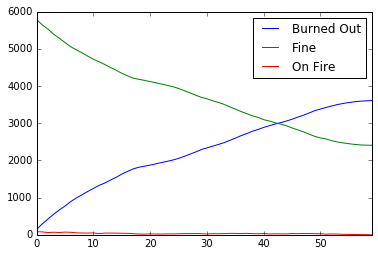

In [16]:
results.plot()

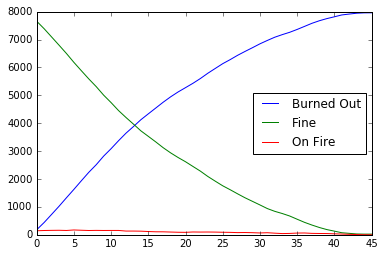

In [17]:
fire = ForestFire(100, 100, 0.8)
fire.run_model()
results = fire.dc.get_model_vars_dataframe()
results.plot()

In [18]:
param_set = dict(height=50, # Height and width are constant
                 width=50,
                 # Vary density from 0.01 to 1, in 0.01 increments:
                 density=np.linspace(0,1,101)[1:])

In [19]:
# At the end of each model run, calculate the fraction of trees which are Burned Out
model_reporter = {"BurnedOut": lambda m: (ForestFire.count_type(m, "Burned Out") / 
                                          m.schedule.get_agent_count()) }

In [20]:
# Create the batch runner
param_run = BatchRunner(ForestFire, param_set, model_reporters=model_reporter)

In [21]:
param_run.run_all()

100%|██████████| 100/100 [00:09<00:00,  4.87it/s]


In [22]:
df = param_run.get_model_vars_dataframe()

In [23]:
df.head()

,BurnedOut,Run,density,height,width
0,0.866197,63,0.64,50,50
1,0.999081,86,0.87,50,50
2,0.695623,58,0.59,50,50
3,0.996542,81,0.82,50,50
4,0.055690,30,0.31,50,50


(0, 1)

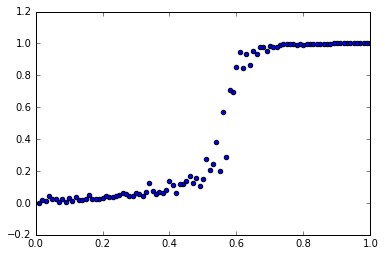

In [24]:
plt.scatter(df.density, df.BurnedOut)
plt.xlim(0,1)

100%|██████████| 500/500 [00:47<00:00,  5.32it/s]


(0, 1)

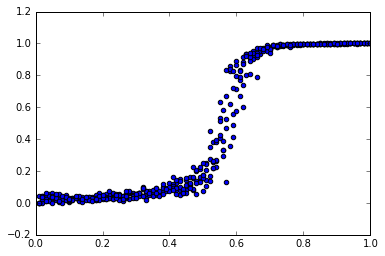

In [25]:
param_run = BatchRunner(ForestFire, param_set, iterations=5, model_reporters=model_reporter)
param_run.run_all()
df = param_run.get_model_vars_dataframe()
plt.scatter(df.density, df.BurnedOut)
plt.xlim(0,1)